<a href="https://colab.research.google.com/github/dataforgoodfr/batch7_satellite_ges/blob/master/Find_Peaks_with_LSTM_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Loading Data


In [1]:
import sys
import pandas as pd 
import math
%matplotlib inline 
import os 
from scipy.optimize import curve_fit
import numpy as np
import torch
from torch import nn
import copy
pd.options.display.max_columns = 100

from tqdm import tqdm
import seaborn as sns
sys.path.append('/content/drive/My Drive')
from google.colab import drive
drive.mount('/content/drive')
input_dir = r'http://courty.fr/OCO2/'
df_res = pd.read_csv(input_dir + "result_for_oco2_1808.csv", sep=",")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#data_1610 = pd.read_csv("http://courty.fr/OCO2/oco2_1610.csv", sep=";")
#data_1705 = pd.read_csv("http://courty.fr/OCO2/oco2_1705.csv", sep=";")
#data_1803 = pd.read_csv("http://courty.fr/OCO2/oco2_1803.csv", sep=";")
#data_1805 = pd.read_csv("http://courty.fr/OCO2/oco2_1805.csv", sep=";")
data_1808 = pd.read_csv("/content/drive/My Drive/oco2_1808_light.csv", sep=";")
#data_1809 = pd.read_csv("http://courty.fr/OCO2/oco2_1809.csv", sep=";")

data_1808.head()



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,sounding_id,latitude,longitude,xco2,xco2_uncert,orbit,windspeed_u,windspeed_v
0,2018080100462105,-33.015541,-164.508881,405.143188,0.491368,21709,3.749916,9.128431
1,2018080100462137,-32.988529,-164.553787,404.893677,0.497189,21709,3.720200,9.087859
2,2018080100462171,-32.996235,-164.435699,404.729431,0.537358,21709,3.815527,9.151507
3,2018080100462172,-32.992409,-164.455872,404.819550,0.498803,21709,3.799832,9.138914
4,2018080100462173,-32.988403,-164.476196,404.706451,0.496855,21709,3.783962,9.126184


In [0]:
def gaussian(x, m, b, A, sig):
    return m * x + b + A / (sig * (2 * np.pi)**0.5) * np.exp(-x**2 / (2*sig**2))

def peak_detection(input_name, df_orbit, orbit_number, orbit_index, output_dir):
    window = 200 # in km
    km_start = df_orbit.loc[orbit_index, 'distance']
    # Slice back because our input point is the middle of the peak
    df_slice = df_orbit.query('distance >= (@km_start-@window/2) and distance <= (@km_start + @window/2)').copy()
    default_return = {'start_index' : df_slice.index[0],
        'end_index': df_slice.index[-1],
        'peak': False}

    # Skip if too few data
    if len(df_slice)<400:
        #print('ERROR : Not enought data')
        return default_return
    med_temp = np.median(df_slice['xco2'])
    # std_temp = np.std(df_slice['xco2']) # Not used
    df_slice['xco2_enhancement'] = df_slice['xco2'] - med_temp
    # Base parameters for : m, b, A, sig
    p0 = (0.,med_temp,30*df_slice.loc[orbit_index,'xco2_enhancement'],10.) 
    #print('Estimated parameters:', p0)
    d_centered = df_slice['distance'] - km_start
    '''
    Gaussian Fit
    scipy.optimize.curve_fit
    scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=default_return, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]¶
    p0 = Initial guess for the parameters (length N).
    sigma : Determines the uncertainty in ydata.
    '''
    popt, _ = curve_fit(f=gaussian, xdata=d_centered, ydata=df_slice['xco2'], sigma = df_slice['xco2_uncert'], p0 = p0, maxfev=20000, ftol=0.5, xtol=0.5) # ftol=0.5, xtol=0.5 to speed up
    sig = abs(popt[3])  # sigma of the Gaussian (km)
    #print(sig)
    if sig < 2 : return default_return  # too narrow
    if 3*sig > window / 2.: return default_return  # too large
    delta = popt[2]/(popt[3]*(2 * np.pi)**0.5)  # height of the peak (ppm)
    if delta < 0: return default_return  # depletion
    #d_plume = df_slice[(d_centered >= -2*sig) & (d_centered <= 2*sig)]
    #d_backg = df_slice[(d_centered < -2*sig) | (d_centered > 2*sig)]

    # we want at least 1 1-km-sounding per km on average on both sides of the peak within 2 sigmas and between 2 and 3 sigmas
    if len(df_slice[(d_centered >= -1*sig) & (d_centered <= 0)]) < int(sig): return default_return
    if len(df_slice[(d_centered <= 1*sig) & (d_centered >= 0)]) < int(sig): return default_return
    if len(df_slice[(d_centered >= -3*sig) & (d_centered <= -2*sig)]) < int(sig): return default_return
    if len(df_slice[(d_centered <= 3*sig) & (d_centered >= 2*sig)]) < int(sig): return default_return
    # check the quality of the fit
    d_peak = df_slice[(d_centered >= -4*sig) & (d_centered <= 4*sig)]
    d_peak_distance = d_peak['distance'] - df_slice.loc[orbit_index, 'distance']
    R = np.corrcoef(gaussian(d_peak_distance,*popt), d_peak['xco2'])
    if R[0,1]**2 < 0.25 : return default_return
    #print('orbit_index',orbit_index, 'Number of good fit',good_find, 'Sigma:', sig, 'Ampleur de l\'émission de CO²:',delta,'Coef de coreflation',R[0,1])
    # TODO: Add filename of input to be able to load it later
    print(df_slice.columns)
    peak = {
        'sounding_id' : df_slice.loc[orbit_index, 'sounding_id'],
        'latitude' : df_slice.loc[orbit_index, 'latitude'],
        'longitude' : df_slice.loc[orbit_index, 'longitude'],
        'orbit' : orbit_number,
        'slope' : popt[0],
        'intercept' : popt[1],
        'amplitude' : popt[2],
        'sigma': popt[3],
        'delta': delta,
        'R' : R[0,1],
        'windspeed_u' : df_slice.loc[orbit_index, 'windspeed_u'],
        'windspeed_v' : df_slice.loc[orbit_index, 'windspeed_v'],
        'peak_index': orbit_index,
        'start_index' : df_slice.index[0],
        'end_index': df_slice.index[-1],
        'peak' : True
    }
    # Save souding data around peak
    df_slice['distance'] = df_slice['distance'] - df_orbit.loc[orbit_index, 'distance']
    filename = 'peak_data' + input_name + '-o' + str(orbit_number) + '-i' + str(orbit_index) + '.json'
    df_slice.to_json(os.path.join(output_dir, filename), orient='records')
    return peak

def gaussian_fit_on_df(df_full, input_name='', output_dir=''):
    # spatial window for the detection (km)
    peak_found_number = 0
    peak_founds = []
    dfs = []
    for orbit in tqdm(df_full['orbit'].unique(), desc='Orbit'):
    #for orbit in tqdm([22061, 21928, 16134, 21715], desc='Orbit'):
        df_orbit = df_full[df_full['orbit'] == orbit].copy()
        if len(df_orbit) < 500:
            continue
        # Compute sounding distance from the begining of the orbit
        latitude_origin = df_orbit.iloc[0]['latitude']
        longitude_origin = df_orbit.iloc[0]['longitude']
        df_orbit['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df_orbit['latitude'])
            - math.radians(latitude_origin))/2)**2 + math.cos(math.radians(latitude_origin))
            * np.cos(np.radians(df_orbit['latitude'])) * np.sin((np.radians(df_orbit['longitude'])
            - math.radians(longitude_origin))/2)**2))
        df_orbit = df_orbit.sort_values(by=['distance'])
        
        print(df_orbit.head)
        # Loop over the souding id's
        for i, orbit_index in tqdm(enumerate(df_orbit.index), desc='Souding', total=len(df_orbit)):
            try:
                # Work only each n soundings (15 seems good)
                #if i % 15 != 0: continue
                peak = peak_detection(input_name, df_orbit, orbit, orbit_index, output_dir)
                df_orbit.loc[orbit_index,'start_index'] = peak['start_index']
                df_orbit.loc[orbit_index,'end_index'] = peak['end_index']
                df_orbit.loc[orbit_index,'peak'] = False
                if peak['peak']:
                    peak_found_number += 1
                    peak_founds.append(peak)
                    df_orbit.loc[orbit_index,'peak'] = True

                
            except RuntimeError: 
                print('WARNING : Failed for orbit', orbit, 'and index', orbit_index)
        if peak_found_number==0:
            print('NO PEAK FOUND for orbit', orbit)
        else:
            # Save at every orbit, but with same name because we do not empty peak_founds
            filename = 'result_for_' + input_name + '.csv'
            print('Saving to', os.path.join(output_dir, filename))
            df = pd.DataFrame(peak_founds)
            df.to_csv(os.path.join(output_dir, filename))
            peak_found_number = 0

        dfs.append(df_orbit)

    return peak_founds, dfs

In [3]:
total = data_1808[0:12000]

_, dfs = gaussian_fit_on_df(total,'','/content/drive/My Drive')

newdf = \
pd.concat(dfs)


Souding:   0%|          | 22/5417 [00:00<00:25, 214.09it/s]

<bound method NDFrame.head of            sounding_id   latitude   longitude        xco2  xco2_uncert  orbit  \
0     2018080100462105 -33.015541 -164.508881  405.143188     0.491368  21709   
5     2018080100462175 -32.979904 -164.516937  405.248474     0.491248  21709   
4     2018080100462173 -32.988403 -164.476196  404.706451     0.496855  21709   
1     2018080100462137 -32.988529 -164.553787  404.893677     0.497189  21709   
6     2018080100462176 -32.975418 -164.537354  404.594025     0.499444  21709   
...                ...        ...         ...         ...          ...    ...   
5403  2018080101175473  70.003471  155.333786  402.607361     0.729847  21709   
5414  2018080101175577  70.023148  155.400375  403.088531     0.627136  21709   
5407  2018080101175504  70.012314  155.343430  402.681793     0.513250  21709   
5416  2018080101175637  70.054153  155.342606  403.895599     0.584439  21709   
5415  2018080101175636  70.061104  155.304291  404.193481     0.641344  21709  


Souding:  22%|██▏       | 1213/5417 [00:05<00:19, 213.30it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

Souding:  55%|█████▌    | 2988/5417 [00:29<00:37, 63.94it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3021/5417 [00:31<00:56, 42.29it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3027/5417 [00:32<02:41, 14.77it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3031/5417 [00:33<04:48,  8.26it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3034/5417 [00:34<09:02,  4.39it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3037/5417 [00:35<09:42,  4.09it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3039/5417 [00:35<09:25,  4.21it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  56%|█████▌    | 3041/5417 [00:36<09:09,  4.32it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  64%|██████▍   | 3454/5417 [00:39<00:19, 101.72it/s]/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

Souding:  68%|██████▊   | 3667/5417 [00:43<00:34, 51.16it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  78%|███████▊  | 4218/5417 [00:54<00:22, 52.47it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  78%|███████▊  | 4224/5417 [00:55<00:49, 24.07it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  79%|███████▉  | 4281/5417 [00:56<00:22, 50.31it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  79%|███████▉  | 4287/5417 [00:57<00:49, 22.86it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  86%|████████▌ | 4662/5417 [01:04<00:12, 59.78it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  87%|████████▋ | 4700/5417 [01:06<00:16, 42.57it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|████████▉ | 4861/5417 [01:09<00:10, 51.11it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|████████▉ | 4867/5417 [01:10<00:21, 25.36it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|████████▉ | 4873/5417 [01:10<00:28, 18.79it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')
Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  90%|█████████ | 4892/5417 [01:11<00:26, 19.98it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████ | 4918/5417 [01:12<00:15, 31.64it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████ | 4942/5417 [01:13<00:14, 33.71it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  91%|█████████▏| 4947/5417 [01:14<00:23, 20.03it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  92%|█████████▏| 4963/5417 [01:14<00:19, 23.45it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding:  92%|█████████▏| 4968/5417 [01:15<00:26, 17.06it/s]

Index(['sounding_id', 'latitude', 'longitude', 'xco2', 'xco2_uncert', 'orbit',
       'windspeed_u', 'windspeed_v', 'distance', 'start_index', 'end_index',
       'peak', 'xco2_enhancement'],
      dtype='object')



Souding: 100%|██████████| 5417/5417 [01:19<00:00, 68.29it/s] 


Saving to /content/drive/My Drive/result_for_.csv


Souding:   0%|          | 22/6583 [00:00<00:30, 211.90it/s]

<bound method NDFrame.head of             sounding_id   latitude   longitude        xco2  xco2_uncert  \
5417   2018080102225277 -40.560734  172.491547  405.624542     0.349140   
5420   2018080102225307 -40.543144  172.487259  405.134491     0.359491   
5419   2018080102225306 -40.549381  172.512390  405.589355     0.351124   
5418   2018080102225278 -40.554298  172.466339  404.842529     0.400775   
5422   2018080102225336 -40.531837  172.508057  405.468597     0.346476   
...                 ...        ...         ...         ...          ...   
11996  2018080102361906   3.583849  163.031052  406.127197     0.330279   
11995  2018080102361905   3.586636  163.042755  406.225159     0.338991   
11994  2018080102361904   3.589495  163.054398  406.448242     0.334484   
11993  2018080102361902   3.595526  163.077667  405.700195     0.339675   
11999  2018080102361931   3.617343  163.085159  406.841370     0.334660   

       orbit  windspeed_u  windspeed_v     distance  
5417   21710   


Souding:  24%|██▎       | 1559/6583 [00:09<00:54, 92.98it/s] /usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

Orbit: 100%|██████████| 2/2 [02:29<00:00, 74.66s/it]

NO PEAK FOUND for orbit 21710


In [0]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# newdf['xco2']= scaler.fit_transform(newdf.xco2.values.reshape(-1, 1))

405.12008751399793

In [0]:
# def createDataset(df,timeStep=30):
  
#   normal, anomaly = [], []
#   for index, row in  df.iterrows():
#       start = row['start_index']
#       end = row['end_index']
#       v = []

#       for index in range(int(start),int(end)):

#         v.append(df.loc[index,'xco2'])

      
#       if row['peak'] == False : 
#         normal.append(v)
      
#       else:
#         anomaly.append(v)

#   train = normal[:int(0.9*len(normal))]
#   test_n = normal[int(0.9*len(normal)):] 
#   test_an = anomaly


#   return train , test_n, test_an


# train, test_n, test_an = createDataset(newdf)






In [0]:
def createDataset(df,timeStep=30):
  
  normal, anomaly = [], [] 
  ind = []
  for indexr, row in  df.iterrows():
      start = row['start_index']
      end = row['end_index']
      v = []

      for index in range(int(start),int(end)):

        v.append(df.loc[index,'xco2'])

      
      # if row['peak'] == False : 
      normal.append(v)
      ind.append(indexr)
    
      # else:
      #   anomaly.append(v)


  train = normal[:int(0.8*len(normal))]
  test_n = normal[int(0.8*len(normal)):] 
  train_ind = ind[:int(0.8*len(normal))]
  test_ind = ind[int(0.8*len(normal))]
  



  return train , test_n, train_ind, test_ind


train , test_n, train_ind, test_ind = createDataset(newdf)



In [0]:
class Encoder(nn.Module):

  def __init__(self, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.n_features = n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    self.seq_len = x.shape[1]
    x = x.reshape((1,self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [0]:
class Decoder(nn.Module):

  def __init__(self, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x, seq_len):
    self.seq_len = seq_len
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((1, self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [0]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(n_features, embedding_dim).to(device)
    self.decoder = Decoder(embedding_dim, n_features).to(device)

  def forward(self, x):
    seq_len = x.shape[1]
    x = self.encoder(x)
    x = self.decoder(x, seq_len)

    return x

In [0]:
def train_model(model, normal, optimizer, start_epoch, n_epochs):
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  train_dataset = normal[:int(0.7 *len(normal))]
  val_dataset = normal[int(0.7 *len(normal)):]

  for epoch in tqdm(range(start_epoch, n_epochs + 1)):
    
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = torch.tensor(seq_true, dtype=torch.float32).reshape(1,-1,1).to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = torch.tensor(seq_true,  dtype=torch.float32).reshape(1,-1,1).to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
     # best_loss = val_loss
     # best_model_wts = copy.deepcopy(model.state_dict())
    savePath = "/content/drive/My Drive/classifier.pt" 

    checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
    torch.save(checkpoint, savePath)
    
    print('Epoch {0}: train loss {1} val loss {2}'.format(epoch, train_loss,val_loss))



  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [0]:
torch.backends.cudnn.enabled = True 
savePath = "/content/drive/My Drive/classifier.pt" 

model = RecurrentAutoencoder(1,128)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model, history = train_model(
  model,
  train,
  optimizer,
  checkpoint['epoch'],
  n_epochs=60
)


  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
print(torch.__version__)

1.5.0+cu101


In [0]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, batch_first=True)
    (rnn2): LSTM(512, 256, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(256, 256, batch_first=True)
    (rnn2): LSTM(256, 512, batch_first=True)
    (output_layer): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [0]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# print(model(torch.tensor(normal[20]).reshape(1,-1,1).to(device))[2])
# plt.plot(model(torch.tensor(normal[20]).reshape(1,-1,1).to(device)).cpu().detach().numpy(), label = "pred")
# plt.ylim(top = 400)
# plt.ylim(bottom = 410)
# plt.plot(normal[20], label = "original")
# plt.legend()


IndexError: ignored

<Figure size 720x720 with 0 Axes>

In [0]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss().to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = torch.tensor(seq_true).reshape(1,-1,1).to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [0]:
_, losses = predict(model, train)




NameError: ignored

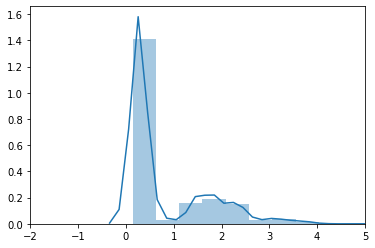

In [0]:
import matplotlib.pyplot as plt
plt.xlim(-2,5)
ax = sns.distplot(losses, bins=50, kde=True);
data_x, data_y = ax.lines[0].get_data()

In [0]:
pd.options.display.max_rows = 1000
pd.DataFrame({'x':data_x,'y':data_y})

,x,y
0,-0.340264,0.005628
1,-0.141126,0.109704
2,0.058011,0.722129
3,0.257148,1.580201
4,0.456286,0.846485
5,0.655423,0.184243
6,0.854561,0.042648
7,1.053698,0.031383
8,1.252836,0.086099
9,1.451973,0.207443


In [0]:
print(np.percentile(losses,90))
print(np.percentile(losses,95))
print(np.percentile(losses,100))

2.2675212144851686
2.9165606021881008
24.467805862426758


In [0]:
print(np.percentile(losses,95))

2.8998409509658813


1.0


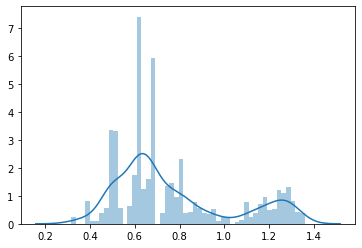

In [0]:
_, losses = predict(model, test_n)
print(sum(l<=1.5 for l in losses)/len(losses))
sns.distplot(losses, bins=50, kde=True);


0.9354838709677419
[15 11  5] [1.42707598 1.93385847 2.44064097 2.94742346]


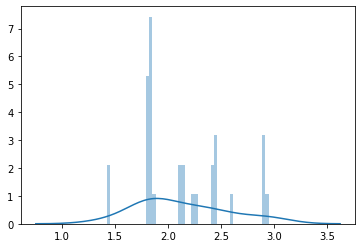

In [0]:
_, losses = predict(model, test_an)

sns.distplot(losses, bins=50, kde=True);
print(sum(l>=1.5 for l in losses)/len(losses))
heights, bin_bounds = np.histogram(losses, bins=3)
print(heights, bin_bounds)

In [0]:
predictions, pred_losses = predict(model, X_test)
sns.distplot(pred_losses, bins=50, kde=True);
correct = sum(l >= 1.053698 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(X_test)}')


NameError: ignored

In [0]:
np.argmax(pred_losses)

5250

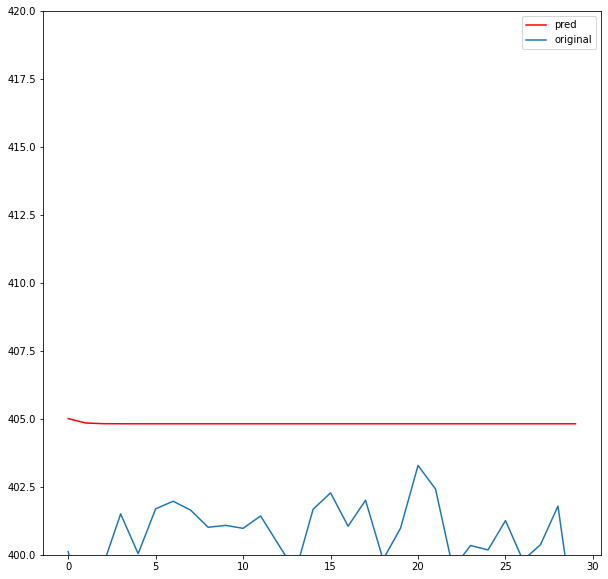

In [0]:
plt.figure(figsize=(10,10))
model(X_train[20].to(device))
plt.plot(model(X_train[5250].to(device)).cpu().detach().numpy(), color = 'red', label = "pred")
plt.ylim(top = 420)
plt.ylim(bottom = 400)
plt.plot(X_train[5250], label = "original")
plt.legend()

In [0]:
df_res

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v
0,0,2018080101035604,25.425072,-177.345490,21709,0.000430,404.902899,-14.694226,-3.987167,1.470254,0.677812,-7.759225,-0.739198
1,1,2018080101060803,32.777554,-179.428162,21709,0.002886,404.622407,1.493849,7.887665,0.075556,0.532213,-5.420354,-0.992332
2,2,2018080101062035,33.441360,-179.630508,21709,-0.002734,404.470875,18.128640,3.086571,2.343144,-0.656713,-4.649583,-0.913302
3,3,2018080101062937,33.919857,-179.779083,21709,-0.006755,404.416030,-11.847855,-3.346435,1.412432,0.592854,-4.035365,-0.879741
4,4,2018080102530302,58.858116,143.781662,21710,0.003719,399.445056,-0.018193,-5.552475,0.001307,0.730703,-3.837832,0.812698
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2734,2018083122422401,27.697588,-142.822235,22159,0.002168,403.383178,34.102413,31.243371,0.435449,0.527938,-7.121493,-0.214880
2735,2735,2018083122430537,29.928204,-143.466751,22159,-0.003651,403.579361,5.744562,5.192406,0.441365,-0.563432,-5.107835,1.853653
2736,2736,2018083122432571,31.114796,-143.827850,22159,0.006210,403.550794,0.286084,14.724687,0.007751,0.542937,-4.404825,2.101457
2737,2737,2018083122433238,31.412222,-143.909012,22159,0.003365,403.564271,15.091141,22.844005,0.263548,0.506012,-4.287163,2.074741
